In [85]:
from functools import lru_cache
import numpy as np
from timeit import default_timer as timer
import matplotlib.pyplot as plt

## XEx 14

### a) 

We write a function that computes $\tau_0(x, z)$

In [86]:
# np.exp := e^x

def tau0(x, z):
    return sum(np.exp((x*y)+(z*y)) for y in [-1, 1])

In [87]:
# Testing tau0
print(tau0(1, -1))
print(tau0(-1, -1))

2.0
7.524391382167263


### b)

Now we create a new function takes as input two functions (each of two variables) and does the same computation as above, i.e., sums out the y-values

In [88]:
def tau_factory(phi1, phi2, yy=[-1, 1]):
    """Eliminates last variable(s) of phi1 and first variable(s) of phi2"""
    return lambda x, z: sum(phi1(x,y)*phi2(z,y) for y in yy)

In [89]:
# Testing tau_factory
tau1 = tau_factory(lambda x,y: np.exp(x * y), lambda y,z: np.exp(y * z))
print(tau1(1, -1))
print(tau1(-1, -1))

2.0
7.524391382167262


### c)

We can use our `tau_factory` to compute the intermediate factors for the Sum-Product VE algorithm. We have already computed `tau1`. Below we compute `tau2` and `tau3`.

In [90]:
tau2 = tau_factory(tau1, lambda z,w: np.exp(2 * z * w))
tau3 = tau_factory(tau2, lambda w,u: np.exp(- w * u))

To test that `tau3` actually computes $\tau_3$ we assume that all the variables are binary taking values in $\{-1, 1\}$.

In [91]:
# This is a very naive way to compute tau3
def tau3_bench(x, u):
    tmp = 0
    for y in [-1, 1]:
        for z in [-1, 1]:
            for w in [-1, 1]:
                tmp += np.exp(x * y) * np.exp(y * z) * np.exp(2 * z * w) * np.exp(- w * u)
    return tmp

In [92]:
print(np.abs(tau3_bench(1, -1) - tau3(1, -1)))
print(np.abs(tau3_bench(-1, -1) - tau3(-1, -1)))

0.0
7.105427357601002e-15


### d)

We now explore the run time of our algorithm. If we suppose that all variables can take $n$ distinct values, then the runtime of `tau3` is $O(n\cdot \text{cost}(\tau_2))$. Similarly, the runtime of `tau2` is given by $O(n\cdot \text{cost}(\tau_1))$ with $\text{cost}(\tau_1) = O(n)$. Thus, the runtime of computing `tau3(-1, 1)` is $O(n^3)$.

In [93]:
out = []
n_seq = np.linspace(2, 100, num=25, dtype=int)
for n in n_seq:
    vals = np.linspace(-1, 1, n)

    tau1 = tau_factory(lambda x,y: np.exp(x * y), lambda y,z: np.exp(y * z), vals)
    tau2 = tau_factory(tau1, lambda z,w: np.exp(2 * z * w), vals)
    tau3 = tau_factory(tau2, lambda w,u: np.exp(- w * u), vals)

    start = timer();
    result = tau3(-1, 1)
    time = timer() - start
    out += [time]
    print(f"{n}: {np.round(time, 2)} s")

2: 0.0 s
6: 0.0 s
10: 0.0 s
14: 0.01 s
18: 0.03 s
22: 0.06 s
26: 0.1 s
30: 0.17 s


34: 0.22 s
38: 0.25 s
42: 0.35 s
46: 0.37 s
51: 0.56 s
55: 0.71 s
59: 0.78 s
63: 0.97 s
67: 1.15 s
71: 1.32 s
75: 1.56 s
79: 2.31 s
83: 3.04 s
87: 3.02 s
91: 3.68 s


Text(1, -3, 'Slope: 2.88')

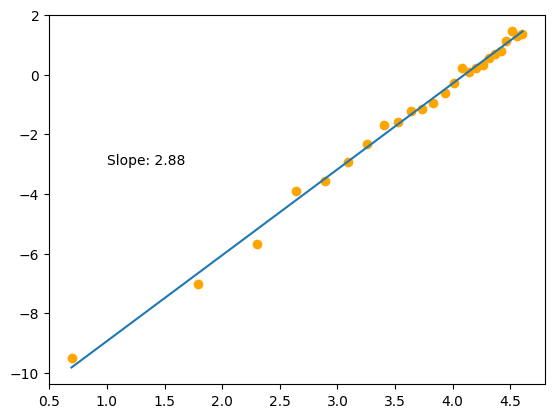

In [ ]:
# Since we expect the relation to be cubic, we plot log-time against log n
plt.scatter(np.log(n_seq), np.log(out), c="orange")

# We fit a regression line.
m, b = np.polyfit(np.log(n_seq), np.log(out), 1)
plt.plot(np.log(n_seq), m*np.log(n_seq) + b)
plt.annotate(f"Slope: {m.round(2)}", (1,-3))

Now let's do the same thing for an algorithm that computes and stores $\tau_1(-1, z)$ as an array instead.

In [ ]:
out = []
n_seq = np.linspace(2, 100, num=25, dtype=int)
for n in n_seq:
    vals = np.linspace(-1, 1, n)
    raise (NotImplementedError("Task: Complete the line below to precompute (to avoid calling tau1 repeatedly)."))
    tau1_z = np.array([... for z in vals]) 
    tau2 = lambda w: sum(tau1_z[idx] * np.exp(2 * z * w) for idx,z in enumerate(vals))
    tau3 = lambda u: sum(tau2(w) * np.exp(- w * u) for w in vals)


    start = timer();
    result = tau3(1)
    time = timer() - start
    out += [time]
    print(f"{n}: {np.round(time, 2)} s")

NotImplementedError: Task: Complete the line below to precompute (to avoid calling tau1 repeatedly).

In [ ]:
# Since we expect the relation to be quadratic, we plot log-time against log n
plt.scatter(np.log(n_seq), np.log(out), c="orange")

# We fit a regression line.
m, b = np.polyfit(np.log(n_seq), np.log(out), 1)
plt.plot(np.log(n_seq), m*np.log(n_seq) + b)
plt.annotate(f"Slope: {m.round(2)}", (1,-3))

---

### LRU cache (least recently used cache)

We define an alternative `tau_factory` function that we will use only for `tau1` to inspect the number of calls = multiplications.

In [ ]:
def tau_factory_logging(phi1, phi2, yy=[-1, 1], lru_maxsize=0):
    """Eliminates last variable(s) of phi1 and first variable(s) of phi2,
    lru caches the last lru_maxsize calls to the returned factor function"""
    @lru_cache(maxsize=int(lru_maxsize))
    def function(x, z):
        global COUNTER
        COUNTER += 1
        return sum(phi1(x,y)*phi2(y,z) for y in yy)
    return function

In [ ]:
n = 40

COUNTER = 0
# ---
vals = np.linspace(-1, 1, n)

tau1 = tau_factory_logging(lambda x,y: np.exp(x * y), lambda y,z: np.exp(y * z), vals, lru_maxsize=0)
tau2 = tau_factory(tau1, lambda z,w: np.exp(2 * z * w), vals)
tau3 = tau_factory(tau2, lambda w,u: np.exp(- w * u), vals)

start = timer();
result = tau3(-1, 1)
time = timer() - start
out += [time]
# ---
print('Without caching / storing tau1(-1, z)')
print(f'Number of multiplications for evaluating tau1: {COUNTER}')
print(f"Runtime: {np.round(time, 2)} s \n")

COUNTER = 0
# ---
vals = np.linspace(-1, 1, n)

tau1 = tau_factory_logging(lambda x,y: np.exp(x * y), lambda y,z: np.exp(y * z), vals, lru_maxsize=n)
tau2 = tau_factory(tau1, lambda z,w: np.exp(2 * z * w), vals)
tau3 = tau_factory(tau2, lambda w,u: np.exp(- w * u), vals)

start = timer();
result = tau3(-1, 1)
time = timer() - start
out += [time]
# ---
print('With caching / storing tau1(-1, z)')
print(f'Number of multiplications for evaluating tau1: {COUNTER}')
print(f"Runtime: {np.round(time, 2)} s")

In [ ]:
# now let's redo the above experiment with storing tau1(-1, z)

out = []
n_seq = np.linspace(2, 100, num=25, dtype=int)
for n in n_seq:
    vals = np.linspace(-1, 1, n)

    tau1 = tau_factory_logging(lambda x,y: np.exp(x * y), lambda y,z: np.exp(y * z), vals, lru_maxsize=n)
    tau2 = tau_factory(tau1, lambda z,w: np.exp(2 * z * w), vals)
    tau3 = tau_factory(tau2, lambda w,u: np.exp(- w * u), vals)

    start = timer();
    result = tau3(-1, 1)
    time = timer() - start
    out += [time]
    print(f"{n}: {np.round(time, 2)} s")

In [ ]:
# Since we expect the relation to be quadratic, we plot log-time against log n
plt.scatter(np.log(n_seq), np.log(out), c="orange")

# We fit a regression line.
m, b = np.polyfit(np.log(n_seq), np.log(out), 1)
plt.plot(np.log(n_seq), m*np.log(n_seq) + b)
plt.annotate(f"Slope: {m.round(2)}", (1,-3))